In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from football_sim import *
plt.rcParams['figure.figsize']=[16,9]

In [2]:
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1718/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1718/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1718/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1718/N1.csv'
                          }
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv'
                          }


In [4]:
all_data=get_data(urls)
#all_data['EN']=add_match(all_data['EN'],'Liverpool',2,'Newcastle',0)
#all_data['EN']=add_match(all_data['EN'],'Tottenham',2,'Huddersfield',0)
#all_data['EN']=add_match(all_data['EN'],'Brighton',2,'Arsenal',1)
#all_data['EN']=add_match(all_data['EN'],'Man City',1,'Chelsea',0)
#all_data['EN']=add_match(all_data['EN'],'Crystal Palace',2,'Man United',3)
all_data['EN'].tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG
285,2018-03-03,Tottenham,Huddersfield,2,0
286,2018-03-03,Watford,West Brom,1,0
287,2018-04-03,Brighton,Arsenal,2,1
288,2018-04-03,Man City,Chelsea,1,0
289,2018-05-03,Crystal Palace,Man United,2,3


In [5]:
#all_data['EN']=add_match(all_data['EN'],'Chelsea',1,'West Brom',0)
all_data['EN'].tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG
280,2018-03-03,Burnley,Everton,2,1
281,2018-03-03,Leicester,Bournemouth,1,1
282,2018-03-03,Liverpool,Newcastle,2,0
283,2018-03-03,Southampton,Stoke,0,0
284,2018-03-03,Swansea,West Ham,4,1
285,2018-03-03,Tottenham,Huddersfield,2,0
286,2018-03-03,Watford,West Brom,1,0
287,2018-04-03,Brighton,Arsenal,2,1
288,2018-04-03,Man City,Chelsea,1,0
289,2018-05-03,Crystal Palace,Man United,2,3


In [6]:
teams = create_teams(all_data)

In [7]:
teams=calibrate(teams,all_data)

In [8]:
EnglishTeams={x:teams[x] for x in teams if teams[x].country=='EN'}
PremierLeague=Season(EnglishTeams)
PremierLeague.process_current_results(all_data['EN'])
PremierLeague.simulate_season(n_scenarios=100000)

In [9]:
PremierLeague.season_report()

simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Man City,100.6,96,105,1,1,100.0,100.00,2.30,0.16,0.00
Liverpool,80.3,74,85,4,2,0.0,98.61,1.70,0.23,0.00
Man United,79.3,73,85,4,2,0.0,97.57,1.26,0.17,0.00
Tottenham,76.2,70,82,5,2,0.0,88.57,1.30,0.14,0.00
Chelsea,70.2,64,76,5,4,0.0,15.19,1.06,0.21,0.00
Arsenal,61.0,55,67,7,6,0.0,0.06,1.18,0.61,0.00
Burnley,53.4,47,60,9,6,0.0,0.00,0.33,0.20,0.00
Leicester,50.9,45,57,10,7,0.0,0.00,0.82,0.59,0.00
Watford,46.6,41,53,13,7,0.0,0.00,0.82,0.83,0.07
Everton,44.1,38,50,16,8,0.0,0.00,0.52,0.92,1.33


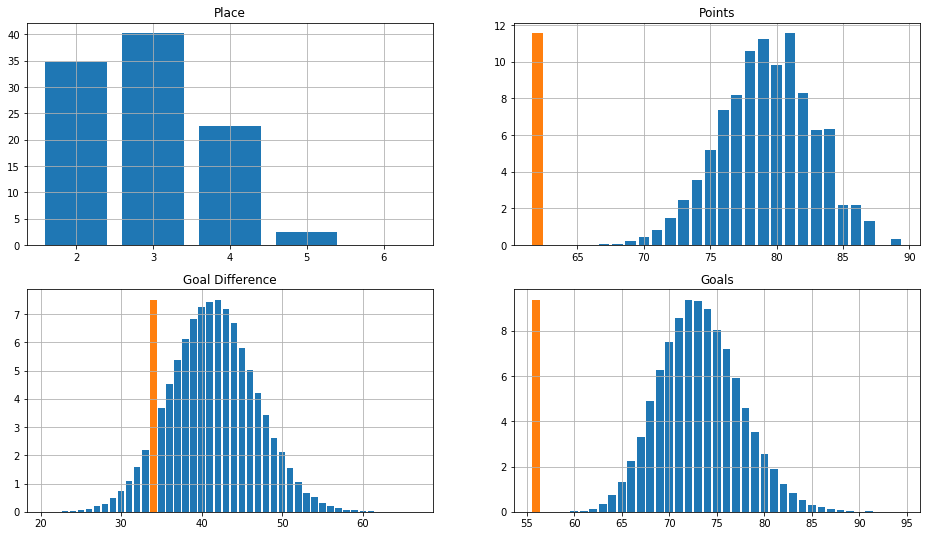

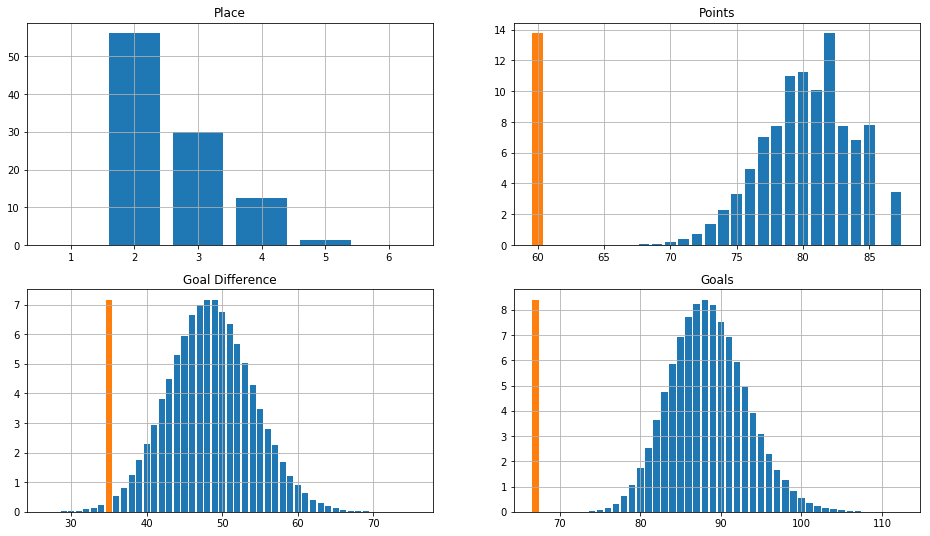

In [10]:
PremierLeague.team_report('Man United')
PremierLeague.team_report('Liverpool')

# Most important matches

array([ 97.568     ,  93.33333333,  98.62937452,  95.94158807])

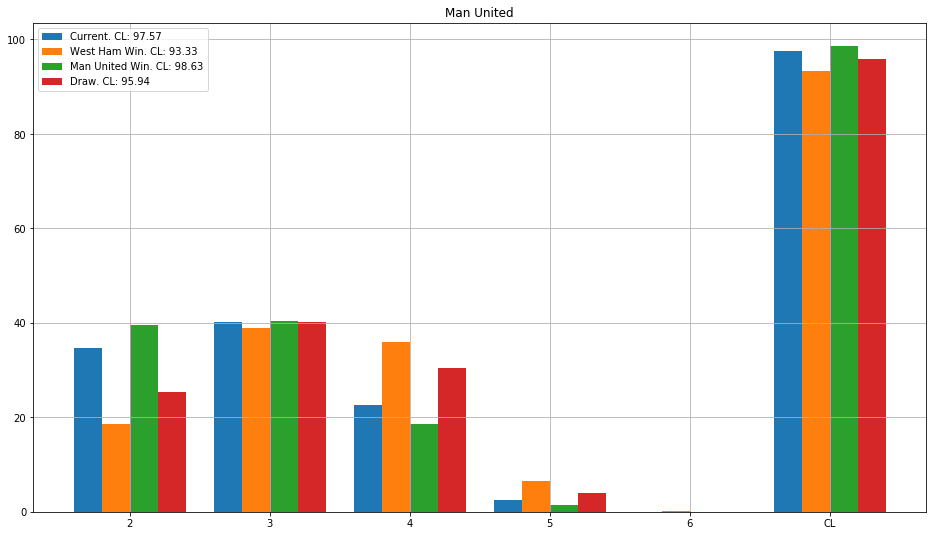

In [22]:
imp=[]
ref_team='Man United'
matches=[]
for x in PremierLeague.matches_to_sim:
    matches.append(x)
    pcl=PremierLeague.what_if(x,ref_team=ref_team,show_plot=False)
    #imp.append(pcl.max()/pcl.min())
    imp.append(pcl.std())
imp=np.array(imp)
matches=np.array(matches)
the_match=matches[imp.argmax()]
PremierLeague.what_if(the_match,ref_team=ref_team)

array([ 97.568     ,  99.32372365,  96.2384334 ,  97.86239448])

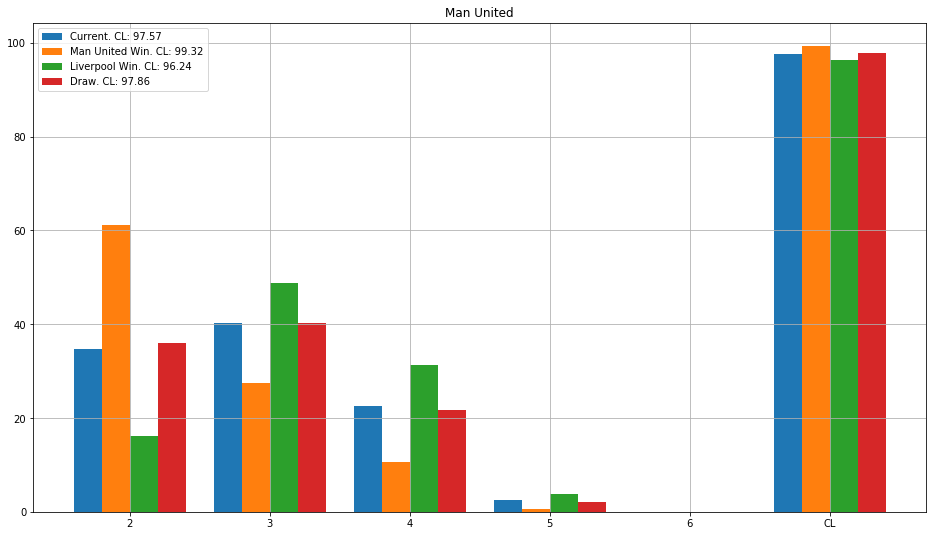

In [19]:
PremierLeague.what_if('Man United v Liverpool',ref_team=ref_team)

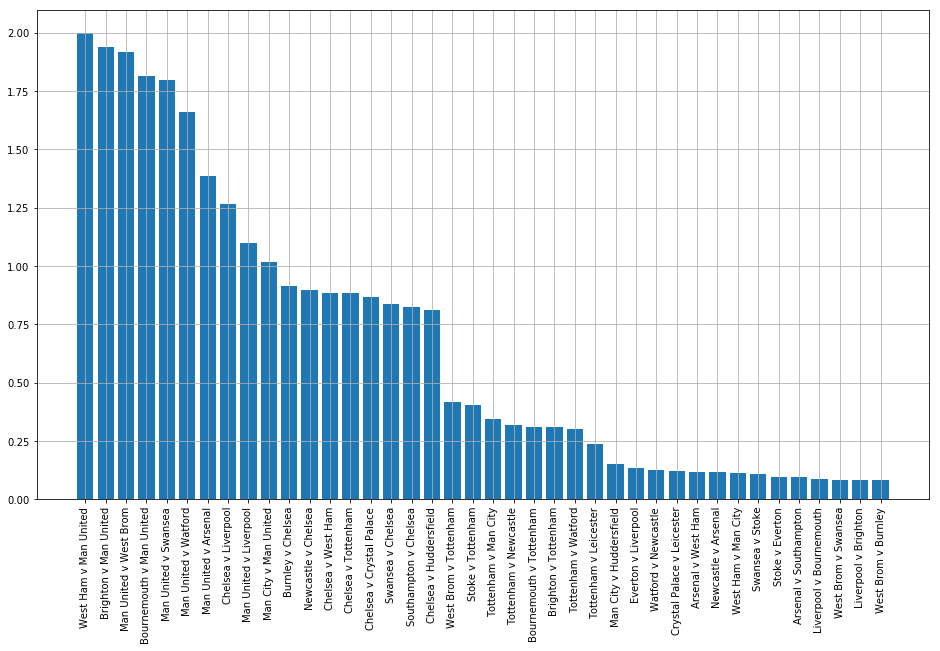

In [13]:
i_sort=(-imp).argsort()
matches=matches[i_sort]
imp=imp[i_sort]
xx=np.arange(40)
plt.bar(xx,imp[xx])
plt.xticks(xx,matches[xx],rotation=90);
plt.grid(True)

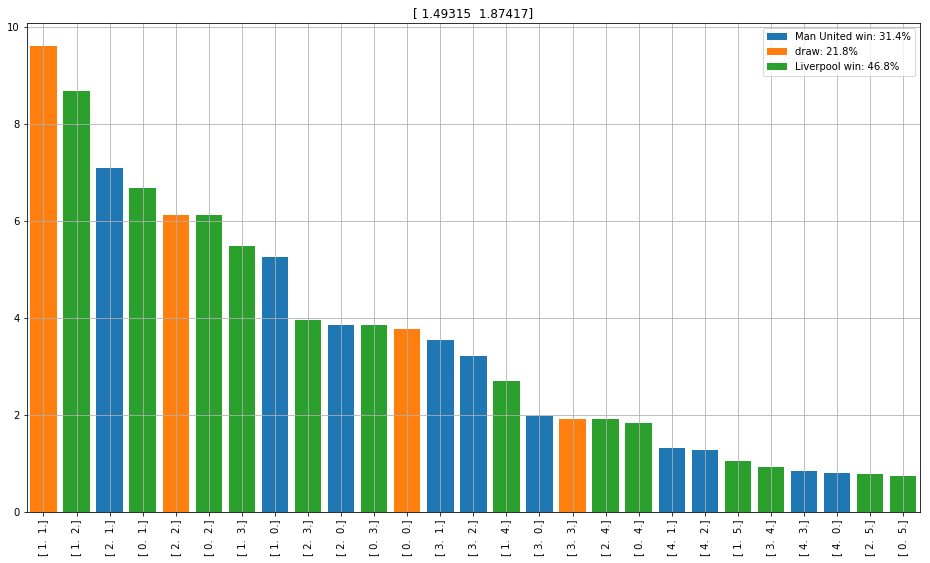

In [17]:
teams['Man United']+teams['Liverpool']

2.257268888888889

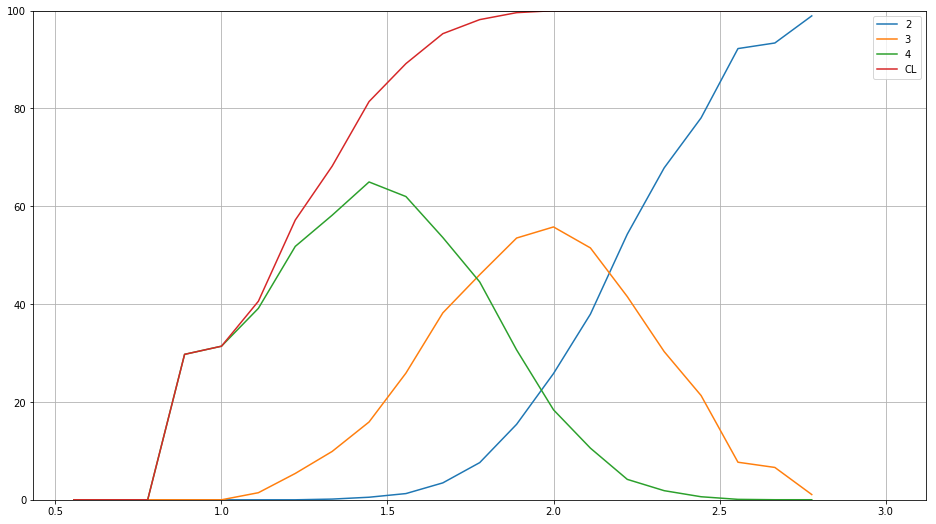

In [23]:
team_name='Man United'
#team_name='Tottenham'
#team_name='Chelsea'
team_name='Liverpool'
i=PremierLeague.team_id[team_name]
ind=PremierLeague.place_per_team[i,:]<=4
tmp=[PremierLeague.matches_to_sim[x] for x in PremierLeague.matches_to_sim ]
n=len([x for x in tmp if x['Home']==team_name or x['Away']==team_name])
#pnts=PremierLeague.points_per_team[i,ind]-PremierLeague.current_points['Man United']
pnts=PremierLeague.points_per_team[i,:]-PremierLeague.current_points[team_name]
plc=PremierLeague.place_per_team[i,:]

nrpnts=np.arange(5,3*n+1)
p=np.zeros([nrpnts.shape[0],5])
p[:]=np.nan
for jj in range(nrpnts.shape[0]):
    ind=pnts==nrpnts[jj]
    if ind.any():
        p[jj,0]=(plc[ind]==2).sum()/ind.sum()
        p[jj,1]=(plc[ind]==3).sum()/ind.sum()
        p[jj,2]=(plc[ind]==4).sum()/ind.sum()
        p[jj,3]=(plc[ind]<=4).sum()/ind.sum()
    

plt.plot(nrpnts/n,100*p[:,0],label='2')
plt.plot(nrpnts/n,100*p[:,1],label='3')
plt.plot(nrpnts/n,100*p[:,2],label='4')
plt.plot(nrpnts/n,100*p[:,3],label='CL')
plt.legend()
plt.grid(True)
plt.ylim([0,100])
#plt.xlabel([0,3])
pnts.mean()/n

In [24]:
TeamSet={x:teams[x] for x in teams if teams[x].means()[0]>=1 and teams[x].country=='EN'}
#GoodTeams={x:teams[x] for x in teams if teams[x].means()[0]>=1.2}

In [25]:
CustomLeague=Season(TeamSet,nr_cl=2,nr_degr=1)
CustomLeague.process_current_results(all_data['EN'])
#CustomLeague.process_current_results(all_data['ES'])
#CustomLeague.process_current_results(all_data['DE'])
#CustomLeague.process_current_results(all_data['NL'])
#CustomLeague.process_current_results(all_data['FR'])
#CustomLeague.process_current_results(all_data['IT'])
#CustomLeague.simulate_season(n_scenarios=100000)

simulation not yet done, simulating
simulation not yet processed, processing


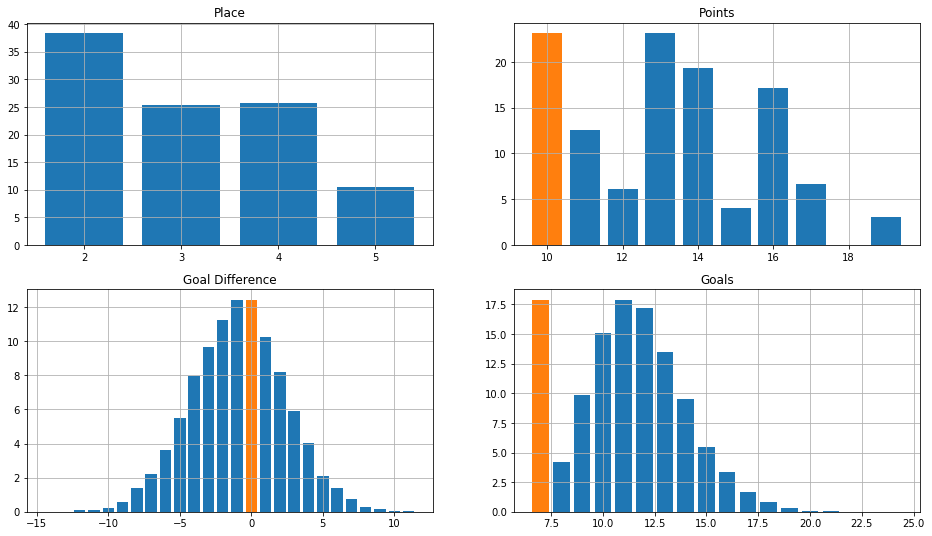

In [26]:
CustomLeague.team_report('Man United')

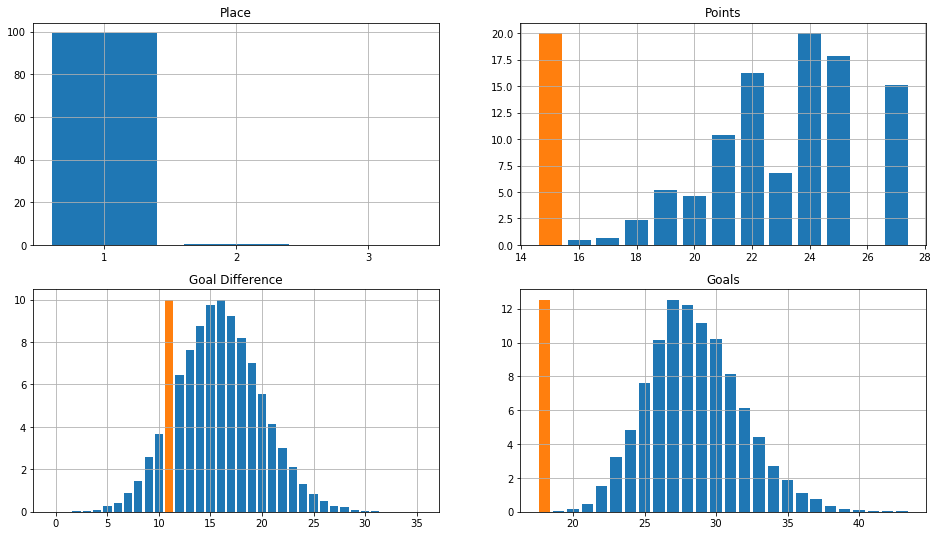

In [17]:
CustomLeague.team_report('Man City')

In [18]:
CustomLeague.season_report()

,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Man City,23.2,19,27,1,1,99.37,99.91,2.36,0.19,0.00
Man United,13.6,10,17,5,2,0.47,34.53,1.22,0.15,2.49
Liverpool,13.4,10,16,5,2,0.04,33.37,1.71,0.26,1.17
Tottenham,12.4,10,16,5,2,0.02,16.06,1.30,0.16,1.67
Chelsea,12.0,9,16,5,2,0.10,16.11,1.13,0.22,4.80
Arsenal,7.8,6,12,6,5,0.00,0.02,1.27,0.56,89.87


In [19]:
SpanishTeams={x:teams[x] for x in teams if teams[x].country=='ES'}
LaLiga=Season(SpanishTeams)
LaLiga.process_current_results(all_data['ES'])
LaLiga.simulate_season(n_scenarios=100000)

In [20]:
LaLiga.season_report()

simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Barcelona,96.5,90,102,1,1,99.30,100.00,2.05,0.10,0.00
Ath Madrid,82.0,75,89,3,2,0.63,99.98,0.92,0.09,0.00
Real Madrid,77.8,70,85,4,2,0.06,99.76,1.72,0.44,0.00
Valencia,72.5,65,80,4,3,0.00,96.28,1.28,0.49,0.00
Villarreal,59.8,53,67,10,5,0.00,2.49,0.75,0.47,0.00
Sevilla,57.1,50,65,12,5,0.00,0.79,0.75,0.63,0.00
Girona,54.2,47,62,13,5,0.00,0.21,0.77,0.51,0.00
Celta,53.6,46,61,13,5,0.00,0.17,1.07,0.87,0.00
Getafe,53.4,46,61,13,5,0.00,0.13,0.54,0.30,0.00
Eibar,52.9,45,60,14,6,0.00,0.10,0.70,0.65,0.00


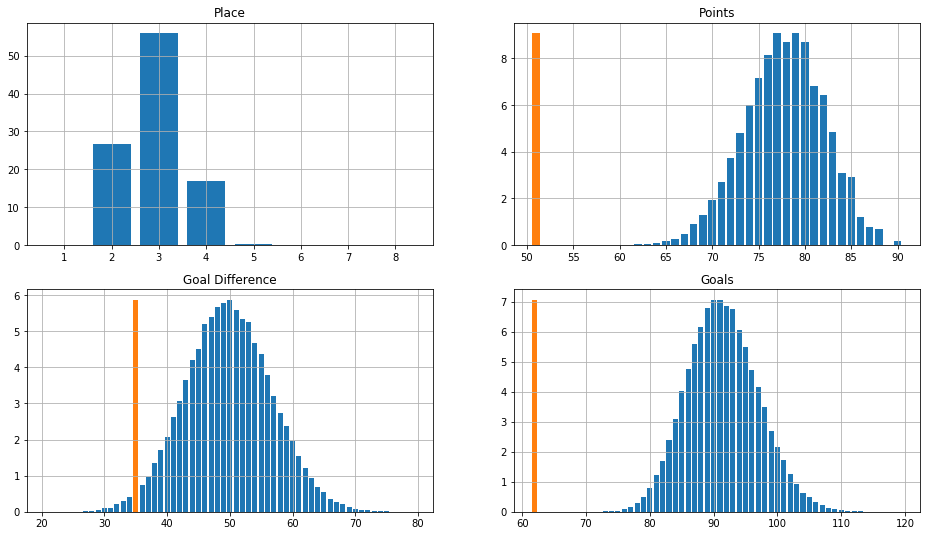

In [21]:
LaLiga.team_report('Real Madrid')

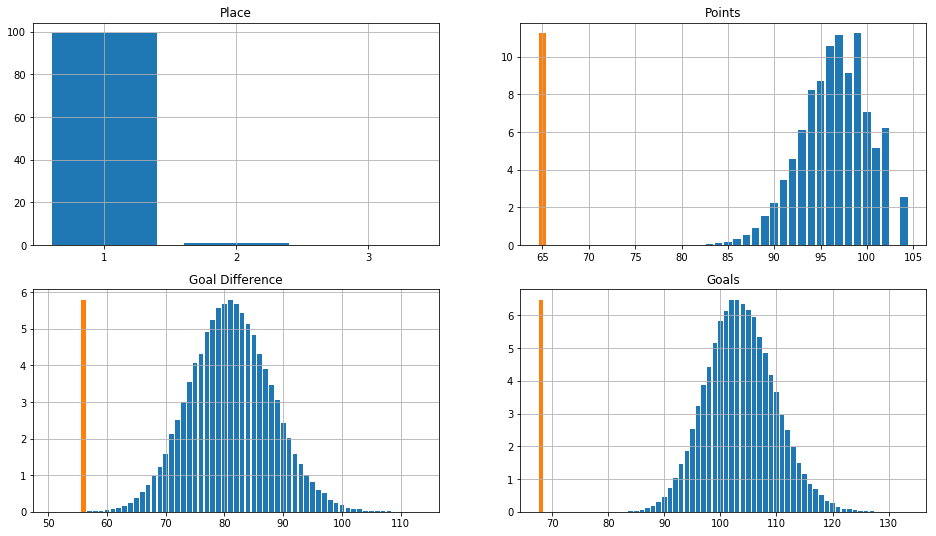

In [22]:
LaLiga.team_report('Barcelona')